# Implement Diffusion Model (small one)

## Import framework

In [ ]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

In [ ]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

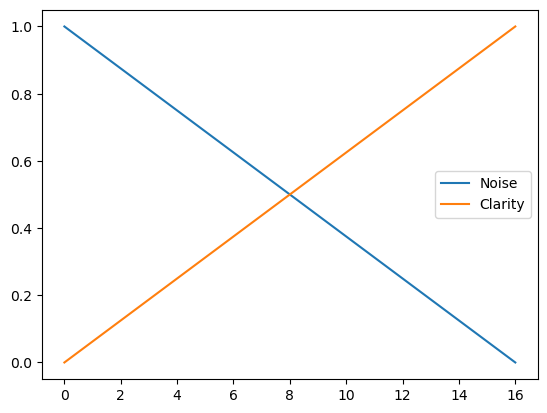

In [34]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

## Import data

In [35]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


## 1_
Look at the data. What is `all_trainset`? Diplay one element of `all_trainset`. Try to print a image 

*Hint: use .permute()*.

In [36]:
all_trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [37]:
all_trainset[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [38]:
all_trainset[0][0].shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


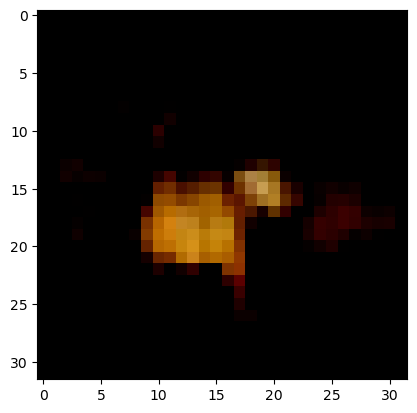

In [39]:
plt.imshow(all_trainset[3][0].permute(1, 2, 0).numpy().astype(np.float32))

## 2_
- Create a list `idx` of idexes of elements of `all_trainset` where the label is a car.
- Then create `sub_trainset` with the class `Subset` from `torch.utils.data`.

In [40]:
# filter training imgs
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

In [41]:
len(sub_trainset)

5000

In [42]:
sub_trainset[0][0]

tensor([[[ 0.3333,  0.3176,  0.3882,  ...,  0.2706,  0.2392,  0.2314],
         [ 0.3176,  0.3490,  0.3412,  ...,  0.2471,  0.2235,  0.2078],
         [ 0.2078,  0.1686,  0.0118,  ...,  0.2627,  0.2314,  0.2078],
         ...,
         [-0.4196, -0.4039, -0.3882,  ..., -0.4431, -0.4667, -0.5216],
         [-0.4667, -0.4588, -0.4353,  ..., -0.4039, -0.4431, -0.4431],
         [-0.4745, -0.4667, -0.4588,  ..., -0.4118, -0.4431, -0.4275]],

        [[ 0.4118,  0.3961,  0.4510,  ...,  0.4039,  0.3961,  0.3882],
         [ 0.4196,  0.4510,  0.4353,  ...,  0.3882,  0.3804,  0.3647],
         [ 0.3333,  0.2941,  0.1294,  ...,  0.3961,  0.3882,  0.3647],
         ...,
         [-0.3412, -0.3333, -0.3333,  ..., -0.4118, -0.4353, -0.4902],
         [-0.4039, -0.3961, -0.3804,  ..., -0.3725, -0.4118, -0.4118],
         [-0.4118, -0.4039, -0.4118,  ..., -0.3804, -0.4118, -0.3961]],

        [[ 0.5529,  0.5373,  0.5922,  ...,  0.6863,  0.6784,  0.6627],
         [ 0.5529,  0.5765,  0.5686,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


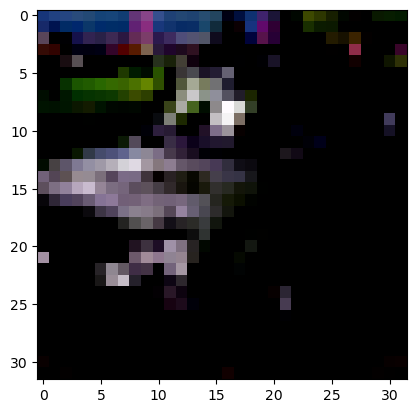

In [43]:
plt.imshow(sub_trainset[3][0].permute(1, 2, 0).numpy().astype(np.float32))

In [44]:
trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

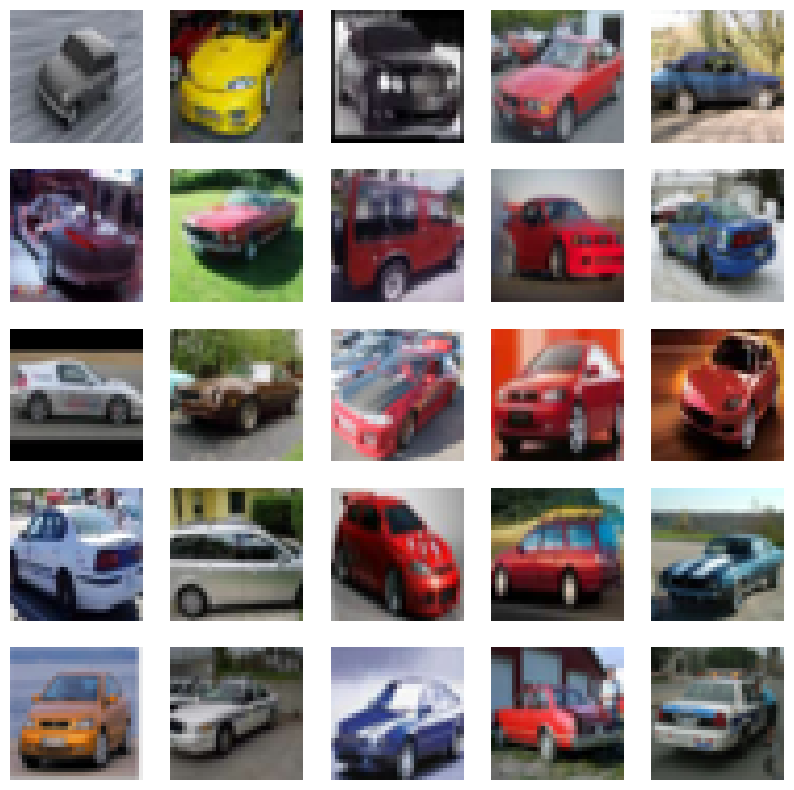

In [45]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

## 3_
Creation of functions.

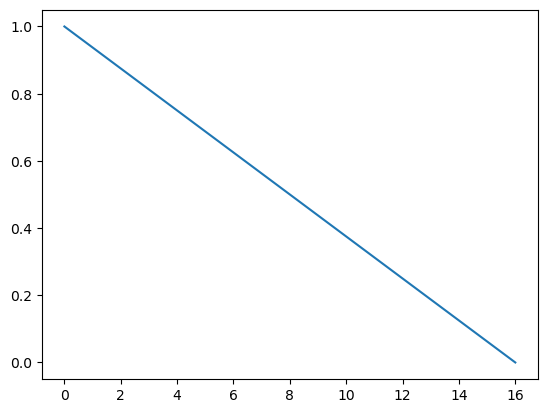

In [46]:
plt.plot(time_bar)

In [47]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x12c87c790>,
 <matplotlib.image.AxesImage at 0x12c7e0e90>)

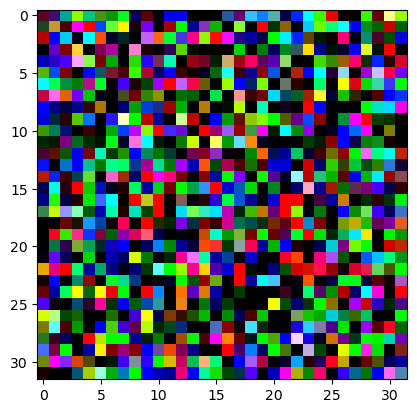

In [48]:
a,b = forward_noise(x[0], 3)
plt.imshow(a[0].permute(1,2,0)), plt.imshow(b[0].permute(1,2,0))

In [49]:
noise = np.random.normal(size=x[:2].shape)

In [50]:
a = time_bar[[2,7]] 
a.shape

(2,)

In [51]:
ar = a.reshape((-1, 1, 1, 1))

In [52]:
ar.shape

(2, 1, 1, 1)

In [53]:
x[:2].shape

torch.Size([2, 3, 32, 32])

In [54]:
x.shape

torch.Size([128, 3, 32, 32])

In [55]:
_

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

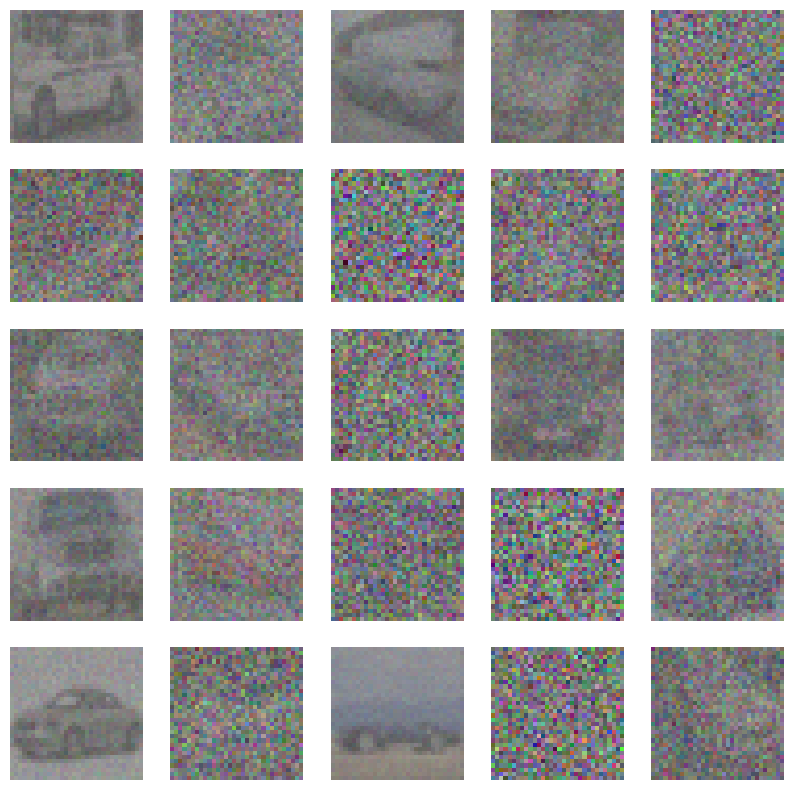

In [56]:
# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

# 4_
Build the class `Block` following this architecture.

## Constructor `__init__`
### 4_1 Convolution
Look at the [the code documentation nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to understand how does the class work.
- What does `in_channels`, `out_channels`, `kernel_size` and `padding` mean?

|Attributes Name  | Type    | in_channels |  out_channels |  kernel_size |  padding|
|-----------------|---------|-------------|---------------|--------------|---------|
|`self.conv_param`|`Conv2d` |`in_channels`|   128         | 3            |   1     |
|`self.conv_out`  |`Conv2d` |`in_channels`|   128         | 3            |   1     |


### 4_2 Linear
Look at the the code documentation.
- What is a Linear layer ? 

|Attributes Name  | Type    | in_features |  out_features | 
|-----------------|---------|-------------|---------------|
|`self.dense_ts`  |`Linear` | 192         |   128         |

### 4_3 Normalization
Look at the the code documentation.
- What is a Layer Normalization ? 

|Attributes Name  | Type    | normalized_shape | 
|-----------------|---------|------------------|
|`self.layer_norm`|`LayerNorm`|`[128, size, size]`|

In [57]:
class Block(nn.Module):
    """The class Block is a subclass of nn.Module, from PyTorch, 
    which is the base class for all neural network modules.
    """
    def __init__(self, in_channels=128, size=32):
        """The constructor of the class. We will define attributes that describe the Neural Network Block.

        Args:
            in_channels (int, optional): Number in input. Defaults to 128.
            size (int, optional): Size of the square image. Defaults to 32.
        """
        super(Block, self).__init__()
        
        # write here the attributes described above (task 4_)
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        """Forward function of Block. 

        Args:
            x_img (torch.float32): Images in input. Shape=()
            x_ts (_type_): _description_

        Returns:
            _type_: _description_
        """
        # write here the attributes described above (task 4_)
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [58]:
a = torch.randn(12, 32, 32)

In [59]:
a.view(-1, 12, 32, 32, 1).shape

torch.Size([1, 12, 32, 32, 1])

In [60]:
a. 

SyntaxError: invalid syntax (3519294265.py, line 1)

In [ ]:
a.shape

torch.Size([32, 3, 32, 32])

# 5_ Forward function of `Block`
Architecture of forward function:
![](task_5.png)


In this sketch, a variable in parenthesis is the name of the output.

In [ ]:
block = Block(in_channels=3)

In [ ]:
print(block)

Block(
  (conv_param): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense_ts): Linear(in_features=192, out_features=128, bias=True)
  (layer_norm): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
)


In [ ]:
x[0].shape

torch.Size([3, 32, 32])

In [ ]:
torch.randn(32, 3, 32, 32).dtype

torch.float32

In [ ]:
out = block.forward(x_img=torch.randn(32, 3, 32, 32),
                    x_ts=torch.full([1, 192], 2, dtype=torch.float))

In [ ]:
out.shape

torch.Size([32, 128, 32, 32])

In [ ]:
out.sum(dim=2).shape

torch.Size([32, 128, 32])

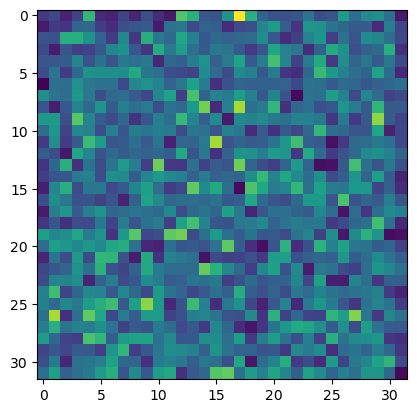

In [ ]:
plt.imshow(out.sum(dim=2).permute(1,0,2)[0].detach().numpy())

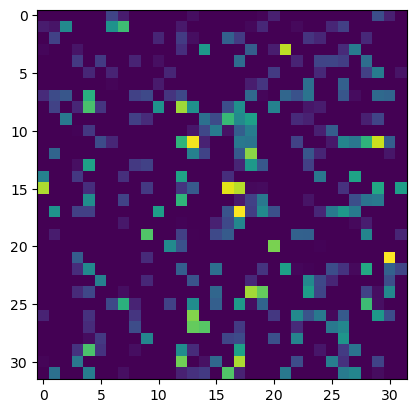

In [ ]:
plt.imshow(out[0][0].detach().numpy())

# 6_
We are now going to create our Model, as a class named `Model`, a subclass of `nn.Module`.

## Constructor `__init__`
### 6_1 time step
At first, we want to create the attribute `self.l_ts` that takes a number in input (on the time line of diffusion process) and returns a vector/row/embeddings of the input time step. Here is the following architecture of the small feed-forward network. There are only two layer (input and output). We add a normalization layer and an activation function rectifier linear. Use `nn.Sequential` and add the following steps/layers inside:

|Attributes Name  | Type    | in_channels |  out_channels | 
|-----------------|---------|-------------|---------------|
|`self.l_ts`      |`Linear` |1            |   192         |
|`self.l_ts`      |`LayerNorm` |-          |   192        |
|`self.l_ts`      |`Relu` |-          |   -        |


### 6_2 down_x
We are building your U-Network, the first part is the left wing, where we decrease the dimension/size of our data. We use the `Block` class that we built in part 4 and 5.

Question: What is the shape of the output of the function `forward` from the class `Block`?

|Attributes Name  | Type    | in_channels |  size | 
|-----------------|---------|-------------|-------|
|`self.down_x32`  |`Block`  | 3           | 32    |
|`self.down_x16`  |`Block`  | 128         | 16    |
|`self.down_x8`   |`Block`  | 128         | 8     |
|`self.down_x4`   |`Block`  | 128         | 4     |

### 6_3 Multi-Layer Perceptron
Once we decreased out data dimension, we use a Multi-Layer Perceptron which combines the data (image) and the time-step in order to remove the noise (somewhat). 
Here is the following architecture of the small feed-forward network. There are only two layer (input and output). We add a normalization layer and an activation function rectifier linear. Use `nn.Sequential` and add the following steps/layers inside:

Why 2240 in input?


|Attributes Name  | Type    | in_channels |  out_channels | 
|-----------------|---------|-------------|---------------|
|`self.mlp`      |`Linear`  |    2240     |   128         |
|`self.mlp`      |`LayerNorm`|-           |   128         |
|`self.mlp`      |`Relu`    |-            |   -           |
|`self.mlp`      |`Linear`  |    128      |   32*4*4      |
|`self.mlp`      |`LayerNorm`|-           |   32*4*4      |
|`self.mlp`      |`Relu`    |-            |   -           |

### 6_4 up_x
Explain why do we use these numbers as `in_channels`?

|Attributes Name  | Type    | in_channels |  size | 
|-----------------|---------|-------------|-------|
|`self.up_x4`  |`Block`  | 32 + 128       | 4     |
|`self.up_x8`  |`Block`  | 256            | 8     |
|`self.up_x4`  |`Block`  | 256            | 16    |
|`self.up_x2`  |`Block`  | 256            | 32    |

### 6_5 Output

|Attributes Name  | Type    | in_channels |  out_channels |  kernel_size |  padding|
|-----------------|---------|-------------|---------------|--------------|---------|
|`self.cnn_output`|`Conv2d` |128          |3              | 1            |   0     |

### 6_6 Optimizer  

What is the Adam optimizer?
|Attributes Name  | Type    | parameters | 
|-----------------|---------|------------------|
|`self.opt`|`torch.optim.Adam`|`(self.parameters(), lr=0.0008)`|

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # time step
        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        # left part of the U-Net
        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)
        
        # multi-layer perceptron
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128), # 4*4*128+192=2240
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        # right part of the U-Net
        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8) # 128+128
        self.up_x16 = Block(in_channels=256, size=16) # 128+128
        self.up_x32 = Block(in_channels=256, size=32) # 128+128
        
        #
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        
        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)
    
    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)
        
        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)
        
        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]
        
        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return x

#model = Model().to(device)
model = Model()

In [ ]:
torch.full([32, 1], 2)#, dtype=torch.float, device=device)

In [41]:
torch.randn(32, 3, 32, 32).shape

torch.Size([32, 3, 32, 32])

In [31]:
def predict(x_idx=None):
    #x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE).to(device)
    x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE)#.to(device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            #x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))
            x = model(x, torch.full([32, 1], t, dtype=torch.float))#, device=device))

    show_examples(x.cpu())

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

NameError: name 'model' is not defined

  0%|          | 0/16 [00:00<?, ?it/s]

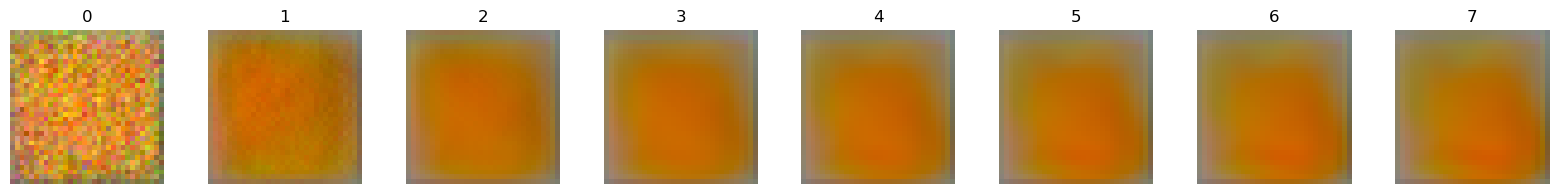

In [45]:
device = 'cpu'
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

In [46]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)
    
    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()
    
    return loss.item()

In [47]:
def train(R=50):
    bar = trange(R)
    total = len(trainloader)
    for i in bar:
        for j, (x_img, _) in enumerate(trainloader):
            loss = train_one(x_img)
            pg = (j / total) * 100
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [ ]:
for _ in range(10):
    train()
    # reduce learning rate for next training
    for pg in model.opt.param_groups:
        pg['lr'] = max(0.000001, pg['lr'] * 0.9)

    # show result 
    predict()
    predict_step()
    plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

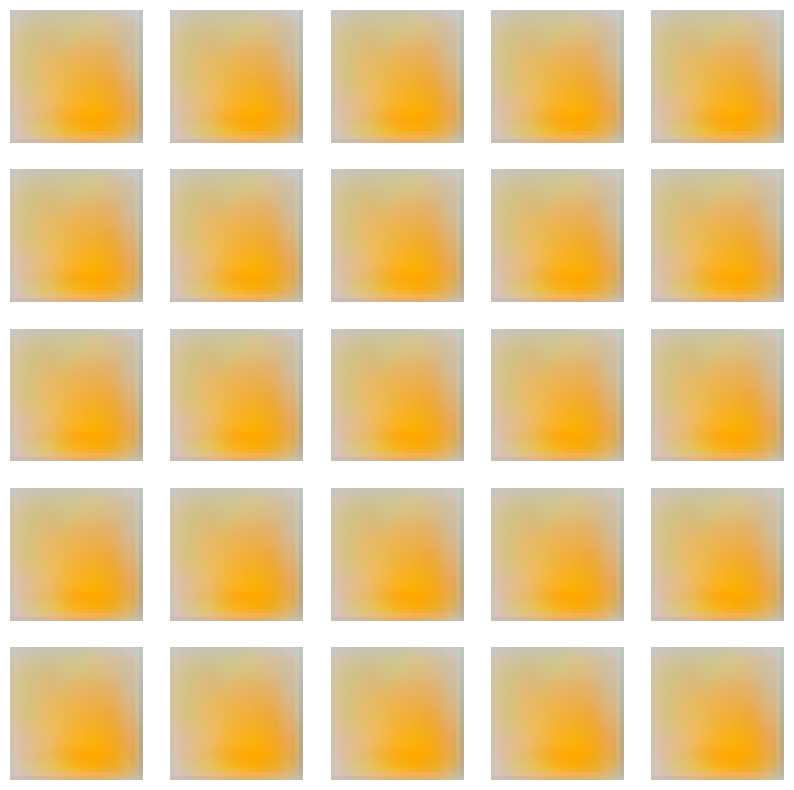

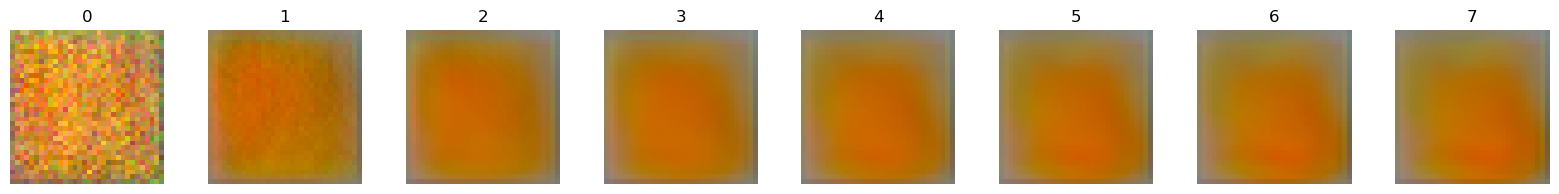

In [49]:
predict()
predict_step()